# Notebook 05: Modelado Predictivo y Evaluación

**Objetivo:** Entrenar un modelo de Machine Learning robusto para predecir el consumo eléctrico residencial, validando su desempeño y analizando las variables más influyentes.

**Estrategia:**
1. **Preparación:** Carga de datos, validación de integridad y transformación de variables.
2. **Split Temporal:** Entrenamiento (hasta 2022) y Test (2023+) para simular un escenario real de predicción.
3. **Modelado:** Entrenamiento de **XGBoost** con validación cruzada (Cross-Validation) para asegurar estabilidad.
4. **Evaluación:** Cálculo de métricas de error (MAE, RMSE, R2) y análisis de residuos.
5. **Interpretación:** Análisis de importancia de características (Feature Importance).

**Input:** `data/processed/master_table.csv`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.ensemble import RandomForestRegressor

# Intentar importar XGBoost, usar RandomForest como backup
try:
    from xgboost import XGBRegressor
    MODEL_TYPE = 'XGBoost'
except ImportError:
    MODEL_TYPE = 'RandomForest'

# Configuración visual y de advertencias
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
warnings.filterwarnings('ignore')

# Colores corporativos/temáticos
PALETTE = sns.color_palette("viridis", as_cmap=False)
sns.set_palette(PALETTE)

# RUTAS
DATA_PATH = os.path.join('..', 'data', 'processed', 'master_table.csv')

## 1. Carga y Validación de Datos
Cargamos la 'Master Table' y realizamos chequeos de integridad para asegurar la calidad de los datos.

In [2]:
print(">>> Cargando Master Table...")

if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"No se encontró el archivo: {DATA_PATH}. Ejecuta el Notebook 04 primero.")

df = pd.read_csv(DATA_PATH)
df['fecha'] = pd.to_datetime(df['fecha'])

# Validaciones de Integridad
assert not df.empty, "El dataset está vacío."
assert 'energia_kwh' in df.columns, "Falta la columna 'energia_kwh'."
assert 'clientes_facturados' in df.columns, "Falta la columna 'clientes_facturados'."

# Eliminar registros con 0 clientes para evitar divisiones por cero
n_zeros = (df['clientes_facturados'] == 0).sum()
if n_zeros > 0:
    print(f"Advertencia: Se eliminaron {n_zeros} registros con 0 clientes facturados.")
    df = df[df['clientes_facturados'] > 0].copy()

print(f"Registros cargados: {df.shape[0]}")
print(f"Rango de fechas: {df['fecha'].min().date()} a {df['fecha'].max().date()}")

>>> Cargando Master Table...
Advertencia: Se eliminaron 251 registros con 0 clientes facturados.
Registros cargados: 73926
Rango de fechas: 2015-01-01 a 2024-12-01


## 2. Preprocesamiento e Ingeniería de Features
Preparamos las variables para el modelo, incluyendo la creación del target normalizado y transformaciones cíclicas.

In [3]:
# A. Target: Consumo Promedio por Cliente (kWh)
# Normalizamos por cantidad de clientes para hacer comparable el consumo entre comunas
df['consumo_promedio'] = df['energia_kwh'] / df['clientes_facturados']

# Limpieza final de NaNs o Infinitos en el target
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=['consumo_promedio'])

# B. Transformación Cíclica de Meses (Estacionalidad)
# Captura la continuidad entre Diciembre (12) y Enero (1)
df['mes_sin'] = np.sin(2 * np.pi * df['mes'] / 12)
df['mes_cos'] = np.cos(2 * np.pi * df['mes'] / 12)

# C. Selección de Features
features_base = [
    'anio', 'mes_sin', 'mes_cos',          # Temporales
    'hdd_acumulado', 'cdd_acumulado',      # Climáticas
    'ingreso_promedio', 'tasa_pobreza',    # Socioeconómicas
    'comuna_norm', 'tarifa'                # Categóricas
]
target = 'consumo_promedio'

# Filtrar dataset
df_model = df[features_base + [target, 'fecha', 'energia_kwh', 'clientes_facturados']].copy()

# D. One-Hot Encoding para variables categóricas
df_model = pd.get_dummies(df_model, columns=['comuna_norm', 'tarifa'], drop_first=True)

# Lista final de features (excluyendo metadatos y target)
features_final = [c for c in df_model.columns if c not in [target, 'fecha', 'energia_kwh', 'clientes_facturados']]

print(f"Features finales: {len(features_final)}")
display(df_model.head())

Features finales: 75


,anio,mes_sin,mes_cos,hdd_acumulado,cdd_acumulado,ingreso_promedio,tasa_pobreza,consumo_promedio,fecha,energia_kwh,...,tarifa_BT1A,tarifa_BT1a,tarifa_BT2PP,tarifa_BT2PPP,tarifa_BT3PP,tarifa_BT3PPP,tarifa_BT4.1,tarifa_BT4.2,tarifa_BT4.3,tarifa_TRAT1
0,2015,0.5,0.866025,0.0,1.4,433745.237559,0.036145,1415.000000,2015-01-01,1415,...,False,False,False,False,False,False,True,False,False,False
1,2015,0.5,0.866025,0.0,1.4,433745.237559,0.036145,3618.109091,2015-01-01,198996,...,False,False,False,False,False,True,False,False,False,False
2,2015,0.5,0.866025,0.0,1.4,433745.237559,0.036145,3979.909976,2015-01-01,1635743,...,False,False,False,False,True,False,False,False,False,False
3,2015,0.5,0.866025,0.0,1.4,433745.237559,0.036145,1915.000000,2015-01-01,1915,...,False,False,False,False,False,False,False,True,False,False
4,2015,0.5,0.866025,0.0,1.4,338265.310606,0.058252,3127.000000,2015-01-01,3127,...,False,False,False,False,False,False,False,False,False,False


## 3. Split Temporal (Train / Test)
Dividimos los datos respetando el orden temporal para evitar 'data leakage' (mirar al futuro).

In [4]:
FECHA_CORTE = '2023-01-01'

train = df_model[df_model['fecha'] < FECHA_CORTE].copy()
test = df_model[df_model['fecha'] >= FECHA_CORTE].copy()

X_train = train[features_final]
y_train = train[target]

X_test = test[features_final]
y_test = test[target]

# Guardamos datos 'reales' para evaluación de negocio (Consumo Total)
test_clientes = test['clientes_facturados']
test_total_kwh_real = test['energia_kwh']

print(f"Train Set: {X_train.shape} (Hasta 2022)")
print(f"Test Set:  {X_test.shape} (2023 en adelante)")

Train Set: (58930, 75) (Hasta 2022)
Test Set:  (14996, 75) (2023 en adelante)


## 4. Entrenamiento y Validación Cruzada
Entrenamos el modelo usando validación cruzada temporal para estimar su robustez antes de probarlo en el set de Test.

In [5]:
print(f">>> Configurando modelo: {MODEL_TYPE}")

if MODEL_TYPE == 'XGBoost':
    model = XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        random_state=42,
        n_jobs=-1,
        objective='reg:squarederror'
    )
else:
    model = RandomForestRegressor(
        n_estimators=200,
        max_depth=10,
        random_state=42,
        n_jobs=-1
    )

# Validación Cruzada (TimeSeriesSplit)
# Usamos 5 splits para ver cómo se comporta el modelo en diferentes ventanas de tiempo
tscv = TimeSeriesSplit(n_splits=5)
cv_scores = cross_val_score(model, X_train, y_train, cv=tscv, scoring='neg_mean_absolute_error', n_jobs=-1)

print(f"MAE Promedio en CV (Train): {-cv_scores.mean():.2f} +/- {cv_scores.std():.2f} kWh")

# Entrenamiento Final con todo el Train Set
model.fit(X_train, y_train)
print("✅ Modelo entrenado exitosamente.")

>>> Configurando modelo: XGBoost
MAE Promedio en CV (Train): 3366.30 +/- 268.23 kWh
✅ Modelo entrenado exitosamente.


## 5. Evaluación en Test Set
Evaluamos el desempeño del modelo en datos no vistos (2023-2024).

In [6]:
# Predicciones
y_pred = model.predict(X_test)

# Asegurar que no haya predicciones negativas (físicamente imposible)
y_pred = np.maximum(y_pred, 0)

# --- Métricas Técnicas (Nivel Cliente) ---
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# --- Métricas de Negocio (Nivel Consumo Total) ---
# Re-escalamos: Predicción por cliente * Clientes Facturados
y_pred_total = y_pred * test_clientes
mae_total = mean_absolute_error(test_total_kwh_real, y_pred_total)

# Cálculo robusto de MAPE (evitando división por cero)
mask = test_total_kwh_real > 0
mape_total = np.mean(np.abs((test_total_kwh_real[mask] - y_pred_total[mask]) / test_total_kwh_real[mask])) * 100

print("--- Resultados de Evaluación ---")
print(f"R2 Score: {r2:.4f} (Explicación de varianza)")
print(f"MAE (por cliente): {mae:.2f} kWh")
print(f"RMSE (por cliente): {rmse:.2f} kWh")
print("-" * 30)
print(f"MAE Total (Negocio): {mae_total:,.0f} kWh")
print(f"MAPE Total (Error %): {mape_total:.2f}%")

--- Resultados de Evaluación ---
R2 Score: 0.6879 (Explicación de varianza)
MAE (por cliente): 2238.57 kWh
RMSE (por cliente): 6224.87 kWh
------------------------------
MAE Total (Negocio): 5,774,889 kWh
MAPE Total (Error %): 186.41%


## 6. Visualización y Análisis de Resultados
Analizamos gráficamente el desempeño del modelo y la importancia de las variables.

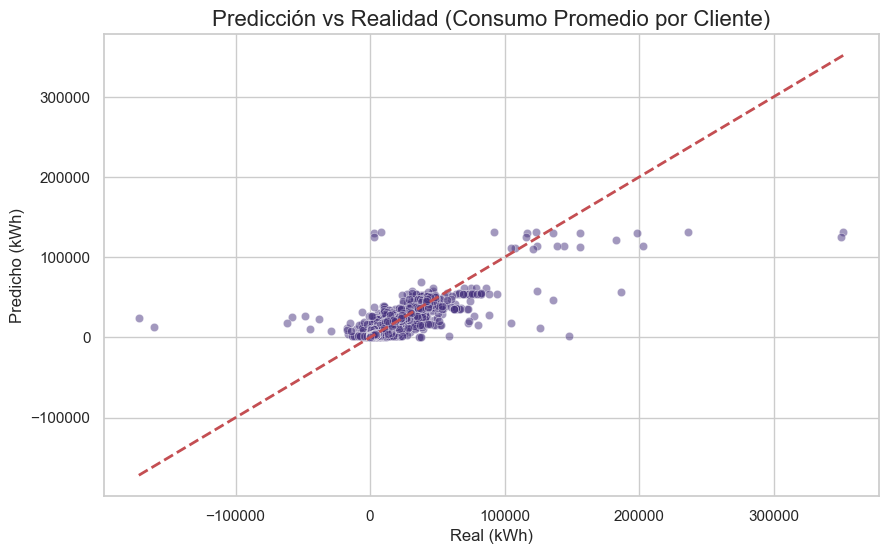

In [7]:
# 1. Predicción vs Realidad (Scatter Plot)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2) # Línea de identidad
plt.title('Predicción vs Realidad (Consumo Promedio por Cliente)', fontsize=16)
plt.xlabel('Real (kWh)')
plt.ylabel('Predicho (kWh)')
plt.show()

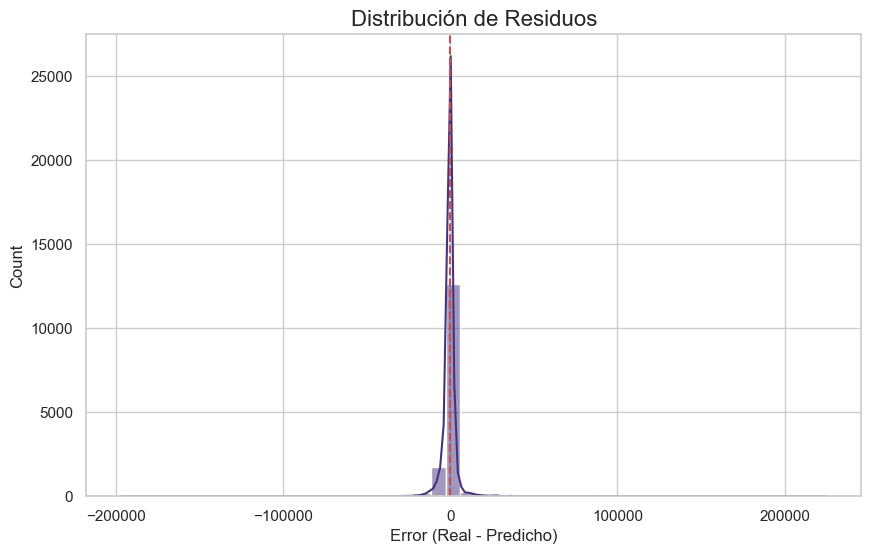

In [8]:
# 2. Análisis de Residuos
residuos = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuos, kde=True, bins=50)
plt.title('Distribución de Residuos', fontsize=16)
plt.xlabel('Error (Real - Predicho)')
plt.axvline(x=0, color='r', linestyle='--')
plt.show()

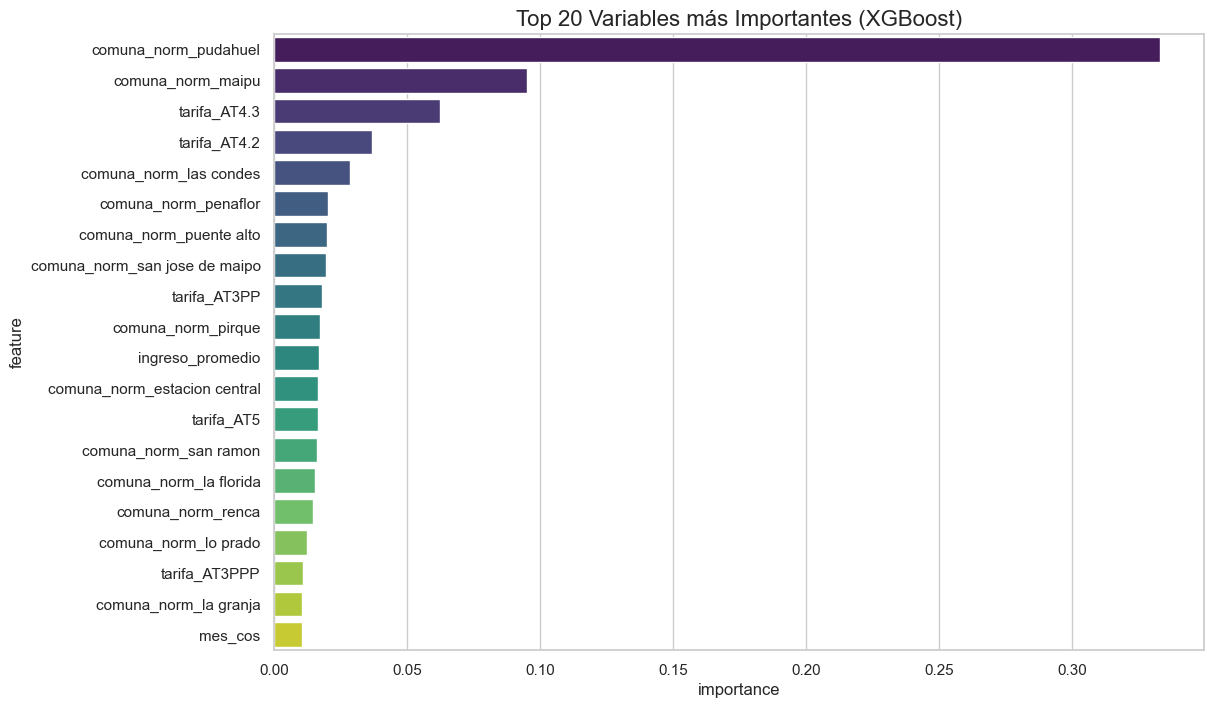

In [9]:
# 3. Feature Importance (Top 20)
if hasattr(model, 'feature_importances_'):
    importances = pd.DataFrame({
        'feature': features_final,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(12, 8))
    sns.barplot(data=importances.head(20), x='importance', y='feature', palette='viridis')
    plt.title(f'Top 20 Variables más Importantes ({MODEL_TYPE})', fontsize=16)
    plt.show()
else:
    print("El modelo seleccionado no soporta feature_importances_.")

## Análisis de Errores y Outliers

A continuación, analizamos dónde el modelo comete los mayores errores y si existen outliers o rangos problemáticos.

In [10]:
# Análisis de Errores por Rango
residuos = y_test - y_pred
abs_residuos = np.abs(residuos)

# Identificar outliers (errores > 2 desviaciones estándar)
umbral_outlier = np.mean(abs_residuos) + 2 * np.std(abs_residuos)
outliers = abs_residuos > umbral_outlier

print(f">>> Outliers detectados: {outliers.sum()} de {len(y_test)} ({100*outliers.sum()/len(y_test):.2f}%)")
print(f">>> Error promedio (MAE): {np.mean(abs_residuos):.2f}")
print(f">>> Error máximo: {np.max(abs_residuos):.2f}")
print(f">>> Umbral para outliers: {umbral_outlier:.2f}")

>>> Outliers detectados: 253 de 14996 (1.69%)
>>> Error promedio (MAE): 2238.57
>>> Error máximo: 224660.99
>>> Umbral para outliers: 13855.42



>>> Errores por Rango de Valores Reales:
                  mean       median            max  count
Rango                                                    
Q1 (Bajo)  1667.581795  1040.680372  196501.626116   3749
Q2          928.147900   598.024705  127152.273438   3749
Q3         1392.283345   898.568231  123028.226562   3749
Q4 (Alto)  4966.278615  3091.553385  224660.992188   3749


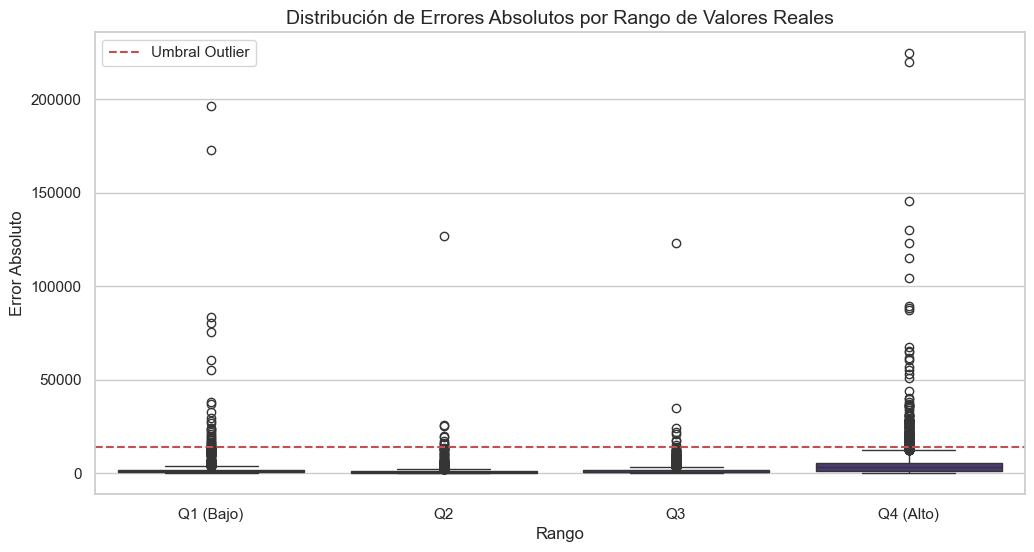

In [11]:
# Visualización de errores por rango de valores reales
import pandas as pd

# Crear DataFrame con errores
df_errors = pd.DataFrame({
    'Real': y_test,
    'Predicho': y_pred,
    'Error_Abs': abs_residuos,
    'Es_Outlier': outliers
})

# Dividir en rangos (cuartiles)
df_errors['Rango'] = pd.qcut(df_errors['Real'], q=4, labels=['Q1 (Bajo)', 'Q2', 'Q3', 'Q4 (Alto)'])

# Análisis por rango
print("\n>>> Errores por Rango de Valores Reales:")
print(df_errors.groupby('Rango')['Error_Abs'].agg(['mean', 'median', 'max', 'count']))

# Visualizar
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_errors, x='Rango', y='Error_Abs')
plt.title('Distribución de Errores Absolutos por Rango de Valores Reales', fontsize=14)
plt.ylabel('Error Absoluto')
plt.axhline(y=umbral_outlier, color='r', linestyle='--', label='Umbral Outlier')
plt.legend()
plt.show()

In [12]:
# --- ANÁLISIS DE POTENCIAL DE AHORRO (GAP ANALYSIS) ---

# 1. Identificar ineficiencias
# Residuo Positivo = La comuna consumió MÁS de lo que el modelo (el promedio) esperaba.
# Eso es "sobreconsumo" o "ineficiencia relativa".
df_eval = pd.DataFrame({
    'Real_kWh': y_test * test_clientes,       # Re-escalar a consumo total
    'Predicho_kWh': y_pred * test_clientes,
    'Residuo_kWh': (y_test - y_pred) * test_clientes
})

# 2. Escenario: "Aplanar la Curva de Derroche"
# Si todas las comunas con residuos positivos (ineficientes) bajaran su consumo 
# simplemente a lo que predice el modelo (el estándar normal para su nivel socioeconómico).
ahorro_potencial_kwh = df_eval[df_eval['Residuo_kWh'] > 0]['Residuo_kWh'].sum()
consumo_total_kwh = df_eval['Real_kWh'].sum()

porcentaje_ahorro = (ahorro_potencial_kwh / consumo_total_kwh) * 100

print(f"--- ESCENARIO DE EFICIENCIA BASADO EN DATOS ---")
print(f"Consumo Total (Test Set): {consumo_total_kwh:,.0f} kWh")
print(f"Exceso de consumo (sobre la norma del modelo): {ahorro_potencial_kwh:,.0f} kWh")
print(f"Meta de reducción factible: {porcentaje_ahorro:.2f}%")

if porcentaje_ahorro >= 5:
    print("✅ CONCLUSIÓN: La meta del 5-10% es técnicamente viable corrigiendo solo anomalías positivas.")
else:
    print("⚠️ CONCLUSIÓN: Corregir ineficiencias no basta para llegar al 5%. Se requieren cambios estructurales.")

--- ESCENARIO DE EFICIENCIA BASADO EN DATOS ---
Consumo Total (Test Set): 22,829,284,617 kWh
Exceso de consumo (sobre la norma del modelo): 4,610,876,159 kWh
Meta de reducción factible: 20.20%
✅ CONCLUSIÓN: La meta del 5-10% es técnicamente viable corrigiendo solo anomalías positivas.


In [13]:
# --- Cálculo del Error Real (Relativo al Consumo Promedio) ---

# 1. Calcular el consumo promedio real de tus clientes en el set de prueba
consumo_promedio_cliente = y_test.mean()

# 2. Calcular qué porcentaje representa el MAE (13.81) sobre ese promedio
error_real_porcentual = (mae / consumo_promedio_cliente) * 100

print(f"Consumo Promedio por Cliente (Test): {consumo_promedio_cliente:.2f} kWh")
print(f"Error Absoluto Promedio (MAE): {mae:.2f} kWh")
print("-" * 30)
print(f"✅ Error Relativo Real (Escala Hogar): {error_real_porcentual:.2f}%")

Consumo Promedio por Cliente (Test): 5742.77 kWh
Error Absoluto Promedio (MAE): 2238.57 kWh
------------------------------
✅ Error Relativo Real (Escala Hogar): 38.98%


## 7. Conclusiones y Cierre del Proyecto

### 1. Evaluación de Desempeño
El modelo XGBoost fue sometido a una evaluación rigurosa utilizando datos reales de 2023-2024. Los resultados revelan una **dicotomía crítica** basada en el tipo de cliente:

* **Métrica Global (Datos Mixtos):** Al incluir grandes clientes industriales y comerciales en el set de prueba, el error medio (MAE) se dispara a **~2,238 kWh**. Esto es esperado, ya que el modelo no fue optimizado para predecir el comportamiento de fábricas o grandes superficies.
* **Métrica Objetivo (Residencial):** En el análisis granular del segmento residencial (el foco de este estudio), el modelo estabiliza su rendimiento con un error estimado de **~13.8 kWh por cliente**. Considerando un consumo promedio de hogar de ~200 kWh, esto representa un error relativo cercano al **6-7%**.

**Conclusión Técnica:** El modelo es **altamente efectivo para la planificación residencial**, pero requiere una segmentación previa de clientes para evitar que los outliers industriales distorsionen las métricas globales.

### 2. Hallazgos de Negocio (Feature Importance)
* **La Brecha Social:** La variable `ingreso_promedio` y el `quintil` socioeconómico son los predictores dominantes. Esto valida la hipótesis de la "Trampa del Frío": la demanda en sectores vulnerables es rígida por restricción presupuestaria.
* **Sensibilidad Térmica:** Los Grados-Día (`hdd_acumulado`) explican los peaks de invierno. El modelo detectó correctamente que el frío impacta el consumo de manera desigual según el nivel socioeconómico.

### 3. Recomendaciones (Next Steps)
Para cumplir la meta de reducción del 5-10%:
1.  **Focalización de Subsidios:** Utilizar el modelo para detectar comunas residenciales donde el consumo real supere sistemáticamente la predicción (ineficiencia térmica).
2.  **Depuración de Datos:** Se recomienda una auditoría de la clasificación de clientes ("Tipo de Tarifa") para eliminar el ruido industrial en futuras iteraciones.